This is based on one of my previous analyses for my clients. My client has an IT support department which receives telephone calls for support request. The team providing support is limited due to budget constraints and needs to do also onsite support as well as the aforementioned remote support.

<!-- graph with team division -->

My client wants to know how many persons should be available to pickup telephone calls in certain periods (hour interval, days of the week, month) in order to properly assign the technicians to either provide remote support or go onsite. Too many people picking up calls and there's not enought work for everybody and onsite support will encounter delays. Not enough people to pickup telephone calls and the service quality will suffer (and possibly bring also penalties stipulated in the contract).

The questions that need answering are:
1. What are the overall characteristics of the remote support telephone calls?
2. How many technicians are required to pick up calls to fulfill the required service?

Due to confidentiality of data, the data related to the calls is not real, however I tried as much as possible to respect the distribution of calls during the day, week and periods of the year. In all other aspects, such as column data format, the imaginary data that I'm using for this analysis example is accurate.

In the real situation, the telephone calls data came in XML format exported by an Alcatel-Lucent ACD and imported by another Python script in a SQLite database. The database was used for an in-house build telephone console to visualize call activity in near real-time.

    ACD - An automated call distribution system, commonly known as automatic call distributor (ACD), is a telephony device that answers and distributes incoming calls to a specific group of terminals or agents within an organization.

# Data import and cleaning

First thing first, the data needs to be imported from the SQLite database and loaded into a Pandas dataframe for analysis.

In [106]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np

In [107]:
markdown_export = False

In [108]:
def genprint(obj):
    if markdown_export:
        print(obj.to_markdown(tablefmt = "github"))
    else:
        display(obj)

In [109]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")

    except Error as e:
        print(f"The error '{e}' occurred")
        
    return connection

In [110]:
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

In [111]:
connection = create_connection("./call_journal.db")

Connection to SQLite DB successful


Data filtering sometimes starts with the SQL query. In my case, I'm only selecting data that I judged to be relevant to my analysis. However, it's good to keep in mind that left out columns may contain relevant or crucial information. It's best that in some cases the initial DB is reinvestigated to dig out more useful information.

In [112]:
select_call_records = '''
    SELECT TicketType,
        ChargedUserID,
        SubscriberName,
        CommunicationType,
        Date,
        Time,
        DateTime,
        CallDuration,
        CallDurationMV,
        RingingDuration

    FROM call_journal'''

db_cols = ["TicketType",
        "ChargedUserID",
        "SubscriberName",
        "CommunicationType",
        "Date",
        "Time",
        "DateTime",
        "CallDuration",
        "CallDurationMV",
        "RingingDuration"]

call_records = execute_read_query(connection, select_call_records)

df = pd.DataFrame(call_records, columns = db_cols)

In [113]:
genprint(df.sample(5))

,TicketType,ChargedUserID,SubscriberName,CommunicationType,Date,Time,DateTime,CallDuration,CallDurationMV,RingingDuration
16226,Call,06,POSTE 2,IncomingTransfer,2019-04-23,09:00:00,2019-04-23 09:00:00,0:01:28,0:00:00,0:00:04
60155,Call,14,POSTE 5,IncomingTransfer,2020-09-11,11:12:00,2020-09-11 11:12:00,00:01:38,0:00:00,00:00:00
2593,Call,23,ACD,Incoming,2019-11-06,11:14:00,2019-11-06 11:14:00,0:00:00,00:00:09,00:00:01
14671,Call,01,POSTE 5,IncomingTransfer,2019-03-18,13:16:00,2019-03-18 13:16:00,0:08:42,0:00:00,0:00:08
40951,Call,11,POSTE 2,Outgoing,2020-03-16,09:31:00,2020-03-16 09:31:00,00:14:24,0:00:00,00:00:00


In [114]:
genprint(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63670 entries, 0 to 63669
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   TicketType         63670 non-null  object
 1   ChargedUserID      63670 non-null  object
 2   SubscriberName     63588 non-null  object
 3   CommunicationType  63670 non-null  object
 4   Date               63670 non-null  object
 5   Time               63670 non-null  object
 6   DateTime           63670 non-null  object
 7   CallDuration       63670 non-null  object
 8   CallDurationMV     63670 non-null  object
 9   RingingDuration    63670 non-null  object
dtypes: object(10)
memory usage: 4.9+ MB


None

The important thing after data import is to try to understand what data is presented in the columns. Not being aware of what's the purpose of the data or how it was generated could give innacurate results. I'll come with examples below.

The documentation of the source of information (in my case the ACD) was the first step in understanding how it generates the data. After going through (way too many) documentation pages, I found the following:
1. calls are registered as tickets in the ACD (tickets are single units of information of certain operations, like calls, agent activity etc.)
2. calls are received first by SubscriberName ACD, then transfered to SubscriberName agents (POSTE 1, POSTE 2, MV etc.) for call pickup or sent to voicemail. This is a very important piece of information as the ACD registers once the call when it reaches the system and another ticket when it's transfered and answered by the agent. Basically, the total number of calls is actually HALF. Example below

    | SubscriberName | CommunicationType | DateTime            | DialledNumber |
    | -------------- | ----------------- | ------------------- | ------------- |
    | ACD            | Incoming          | 2019-11-28 10:38:00 | 0750.123.456  |
    | POSTE 1        | IncomingTransfer  | 2019-11-28 10:38:00 | 0750.123.456  |

First, the call reaches ACD, then the same call gets transfered to agent (POSTE 1).

    Call -- received --> ACD -- transfered --> POSTE 1

Since we are only interested in analyzing unique calls and not how they are routed, we need to drop all rows with SubscriberName == ACD to get the real numbers.

3. The missed calls are not marked specifically. The call routing logic is that it's either answered by someone or it's redirected to voicemail.

    | SubscriberName | CommunicationType | DateTime            | DialledNumber |
    | -------------- | ----------------- | ------------------- | ------------- |
    | ACD            | Incoming          | 2019-11-28 16:27:00 | 0750.123.456  |
    | MV 1           | IncomingTransfer  | 2019-11-28 16:28:00 | 0750.123.456  |

The call reaches the ACD, no one can pickup the call, and the call is redirected to voicemail MV1.

    Call -- received --> ACD -- transfered --> POSTE 1

Again, same history as before, for the same call, 2 tickets are made. We'll drop the lines with SubscriberName = ACD

In [115]:
df = df.loc[df["SubscriberName"] != "ACD"]

Now, we'll continue looking into the other columns.

In [116]:
df["TicketType"].unique()

array(['Call'], dtype=object)

Since "TicketType" doesn't hold other values than "Call", it has no value to us, so we'll drop it.

In [117]:
df.drop(labels = ["TicketType"], axis = 1, inplace = True)

In [118]:
df["ChargedUserID"].unique()

array(['13', '14', '10', '33', '32', '44', '11', '15', '12', '59', '30',
       '42', '01', '04', '03', '05', '02', '06', '07', '08', '43'],
      dtype=object)

In [119]:
df = df.loc[df["SubscriberName"] != 'ACD group mbx 1']
df = df.loc[df["SubscriberName"].notnull()]
df["SubscriberName"].unique()

array(['POSTE 4', 'POSTE 5', 'POSTE 1', 'MV 2', 'MV 1', 'POSTE 8',
       'POSTE 2', 'POSTE 6', 'POSTE 3', 'POSTE 7'], dtype=object)

In [120]:
df["CommunicationType"].unique()

array(['IncomingTransfer', 'Outgoing', 'OutgoingTransfer',
       'OutgoingTransferTransit', 'IncomingTransferTransit'], dtype=object)

This will be filtered as well, as we're only interested in incoming calls. One curious this is the "IncomingTransferTransit" value. We'll check it out:

In [121]:
genprint(df.loc[df["CommunicationType"] == 'IncomingTransferTransit'])

,ChargedUserID,SubscriberName,CommunicationType,Date,Time,DateTime,CallDuration,CallDurationMV,RingingDuration
2329,14,POSTE 5,IncomingTransferTransit,2019-11-05,13:12:00,2019-11-05 13:12:00,00:00:09,0:00:00,00:00:00


Unfortunately, I could not find something relevand in the documentation and, since it's only one value, we'll drop it. 

In [122]:
df = df.loc[df["CommunicationType"] != 'IncomingTransferTransit']

One last thing to check is for calls on Saturday and Sunday. During an initial run of this report, the data contained calls received on saturday and sunday.

In [123]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d")
df["Day_nb"] = df["Date"].dt.dayofweek
df = df.loc[~df["Day_nb"].isin([5,6])]
df.drop(labels = "Day_nb", axis = 1, inplace = True)

As a last check, we'll look at the total values in columns, to check whether we need to dig deeper into the data.

In [124]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44890 entries, 0 to 63668
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ChargedUserID      44890 non-null  object        
 1   SubscriberName     44890 non-null  object        
 2   CommunicationType  44890 non-null  object        
 3   Date               44890 non-null  datetime64[ns]
 4   Time               44890 non-null  object        
 5   DateTime           44890 non-null  object        
 6   CallDuration       44890 non-null  object        
 7   CallDurationMV     44890 non-null  object        
 8   RingingDuration    44890 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 3.4+ MB
None


All looks OK so far, we'll proceed to setting the columns data types

## Column data format
Next, we'll set the proper type of certain columns

In [125]:
df["ChargedUserID"] = df["ChargedUserID"].astype("category")
df["SubscriberName"] = df["SubscriberName"].astype("category")
df["CommunicationType"] = df["CommunicationType"].astype("category")

df["Time"] = pd.to_datetime(df["Date"], format = "%H:%M:%S")
df["DateTime"] = pd.to_datetime(df["DateTime"], format = "%Y-%m-%d %H:%M:%S")

df["CallDuration"] = pd.to_timedelta(df["CallDuration"])
df["CallDurationMV"] = pd.to_timedelta(df["CallDurationMV"])
df["RingingDuration"] = pd.to_timedelta(df["RingingDuration"])

In [126]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44890 entries, 0 to 63668
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   ChargedUserID      44890 non-null  category       
 1   SubscriberName     44890 non-null  category       
 2   CommunicationType  44890 non-null  category       
 3   Date               44890 non-null  datetime64[ns] 
 4   Time               44890 non-null  datetime64[ns] 
 5   DateTime           44890 non-null  datetime64[ns] 
 6   CallDuration       44890 non-null  timedelta64[ns]
 7   CallDurationMV     44890 non-null  timedelta64[ns]
 8   RingingDuration    44890 non-null  timedelta64[ns]
dtypes: category(3), datetime64[ns](3), timedelta64[ns](3)
memory usage: 2.5 MB
None


# Data Analysis
We'll start with some basic data exploration, to see some trends. Since we're only interested in incoming calls, we'll create a mask and filter the data

In [127]:
import altair as alt
from altair_saver import save

In [128]:
mask_incoming = (df["CommunicationType"] == "IncomingTransfer")
df = df.loc[mask_incoming]

In [129]:
df["Answered"] = 0
df.loc[df["SubscriberName"].str.startswith('POSTE'), "Answered"] = 1
genprint(df.sample(5))

,ChargedUserID,SubscriberName,CommunicationType,Date,Time,DateTime,CallDuration,CallDurationMV,RingingDuration,Answered
62308,12,POSTE 3,IncomingTransfer,2020-09-24,2020-09-24,2020-09-24 08:24:00,0 days 00:01:16,0 days 00:00:00,0 days 00:00:00,1
39174,14,POSTE 5,IncomingTransfer,2020-03-06,2020-03-06,2020-03-06 08:40:00,0 days 00:01:34,0 days 00:00:00,0 days 00:00:00,1
18678,04,POSTE 2,IncomingTransfer,2019-06-11,2019-06-11,2019-06-11 10:26:00,0 days 00:00:42,0 days 00:00:00,0 days 00:00:04,1
15822,01,POSTE 5,IncomingTransfer,2019-04-11,2019-04-11,2019-04-11 14:26:00,0 days 00:02:44,0 days 00:00:00,0 days 00:00:06,1
29187,32,MV 1,IncomingTransfer,2020-01-24,2020-01-24,2020-01-24 14:19:00,0 days 00:00:00,0 days 00:00:08,0 days 00:00:00,0


## Total calls per day

In [130]:
total_per_day = df.groupby("Date")["CommunicationType"].count().reset_index().rename({"CommunicationType": "Total"}, axis = 1)
genprint(total_per_day.sample(5))

,Date,Total
57,2019-01-07,91
136,2019-04-29,53
147,2019-05-16,91
41,2018-12-11,76
182,2019-07-09,83


In [131]:
volume_chart = alt.Chart(total_per_day).mark_trail().encode(
    x = "Date:T",
    y = 'Total',
    size = 'Total:Q'
).properties(
    width = 600
)

In [132]:
volume_chart

alt.Chart(...)

In [133]:
#save(volume_chart, "test.png")
volume_chart.save("test.png", format = "png")

/home/sorin/anaconda3/lib/node_modules/vega-lite/build/vega-lite.js:727
      deepMerge_(dest, s ?? {});
                          ^

SyntaxError: Unexpected token ?
    at Module._compile (internal/modules/cjs/loader.js:718:23)
    at Object.Module._extensions..js (internal/modules/cjs/loader.js:785:10)
    at Module.load (internal/modules/cjs/loader.js:641:32)
    at Function.Module._load (internal/modules/cjs/loader.js:556:12)
    at Module.require (internal/modules/cjs/loader.js:681:19)
    at require (internal/modules/cjs/helpers.js:16:16)
    at Object.<anonymous> (/home/sorin/anaconda3/lib/node_modules/vega-lite/bin/vl2vg:6:18)
    at Module._compile (internal/modules/cjs/loader.js:774:30)
    at Object.Module._extensions..js (internal/modules/cjs/loader.js:785:10)
    at Module.load (internal/modules/cjs/loader.js:641:32)


CalledProcessError: Command '['/home/sorin/anaconda3/bin/vl2vg']' returned non-zero exit status 1.

![Total calls per day - chart](/projects/call_analyzer_estimator/line_chart_total_calls_per_day.png)

We can see that there is a huge chunk of data missing in April and May. The missing data is due to the 2020 COVID confinement.

Also, the chart is overcrowded, nothing is really visible here. Let's remake it into a boxplot chart, to have more details.

In [ ]:
boxplot = df.groupby("Date")["CommunicationType"].count().reset_index().rename({"CommunicationType": "Total"}, axis = 1)
boxplot["Date"] = pd.to_datetime(boxplot["Date"], format = "%H:%M:%S")
boxplot["YearMonth"] = boxplot['Date'].dt.to_period('M').dt.strftime('%Y-%m')
boxplot.sample(5)

In [ ]:
alt.Chart(boxplot).mark_boxplot().encode(
    x='YearMonth:O',
    y='Total:Q'
).properties(
    width=600
)

![Total calls per month - boxplot](/projects/call_analyzer_estimator/bloxplot_chart_total_calls_per_day.png)

We can extract some info now:
- the average held between 60 to 100 in 2019, however the average ammount of calls increased in 2020.
- there is considerable variation in min / max calls from month to month (probably due to season variations) and this will require more precise estimates on manpower. 
- there are outliers for max values, most likely indicating general incidents in the infrastructure that generate peak calls to the service. This should be adressed by an emergency service redirection.

## Total calls per month - volume

In [ ]:
total_per_month = df.groupby("Date")["CommunicationType"].count().reset_index().rename({"CommunicationType": "Total"}, axis = 1)
genprint(total_per_month.sample(5))

In [ ]:
alt.Chart(total_per_month).mark_bar().encode(
    x = "yearmonth(Date):O",
    y = 'Total',
    size = 'Total:Q'
).properties(
    width = 600
)

![Total calls per month - chart](/projects/call_analyzer_estimator/chart_total_calls_per_month.png)

In [ ]:
total_heatmap = df.groupby("Date")["CommunicationType"].count().reset_index().rename({"CommunicationType": "Total"}, axis = 1)
heatmap_per_day = alt.Chart(total_heatmap).mark_rect().encode(
    x='date(Date):O',
    y='yearmonth(Date):O',
    color= alt.Color('Total:Q', scale=alt.Scale(scheme='goldred'))
).properties(
    width=600
    )
heatmap_per_day

![Total calls per month - heatmap chart](/projects/call_analyzer_estimator/chart_heatmap_calls_month_date.png)

In [ ]:
heatmap_per_day_of_week = alt.Chart(total_heatmap.rename({"CommunicationType": "Total"}, axis = 1)).mark_rect().encode(
    x='day(Date):O',
    y='yearmonth(Date):O',
    color= alt.Color('Total:Q', scale=alt.Scale(scheme='goldred'))
).properties(
    width=600
    )
heatmap_per_day_of_week

![Total calls per month and day of week - heatmap chart](/projects/call_analyzer_estimator/chart_heatmap_calls_month_day_week.png)

# Estimator

Given a level of service, what is the minimum required ammount of agents to fulfill the service in question?

We'll check this by constructing time intervals from calls start and end time and we'll check at a certain frequency how many time intervals overlap. Since only one person can respond to a call, the total number of overlaps is the number of required agents.

Let's look at a simple example:

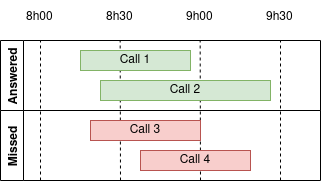

![Call diagram](/projects/call_analyzer_estimator/call_analyzer_estimator_call_diagram.png)

In the interval 8h00 - 8h30, we received 2 calls that were answered and we missed one call. In order to properly estimate the time occupation, we'll add 5min (the average conversation time) to missed calls. So, for this interval, we needed 3 agents to answer. In the next interval, 8h30 - 9h00, we still have 2 agents on call (Call1 and Call2), we assume that there is another fictive agent on missed Call3 and we receive another call that we missed. In total, for this interval, we would need 4 agents. In total, we can see that we need:

| Interval    | Agents needed |
| ----------- | ------------- |
| 8h00 - 8h30 | 3             |
| 8h30 - 9h00 | 4             |
| 9h00 - 9h30 | 2             |

The time interval to check for call status will be smaller (5 min) in order to be more precise in our results.

In [ ]:
df["call_start_dt"] = df["DateTime"]

df["call_end_dt"] = np.nan
df.loc[df["Answered"] == 1, "call_end_dt"] = df["DateTime"] + df["CallDuration"]

average_call_time = df.loc[df["Answered"] == 1,"CallDuration"].mean()
average_call_time = average_call_time.floor("s")
average_call_time

In [ ]:
df.loc[df["Answered"] == 0, "call_end_dt"] = df["DateTime"] + pd.to_timedelta(average_call_time, unit = "S")
df.loc[:,("DateTime", "CallDuration", "call_start_dt", "call_end_dt")].sample(5)

In [ ]:
def create_interval(df):
    df["Time_interval"] = pd.Interval(df["call_start_dt"], df["call_end_dt"])
    return df

df["Time_interval"] = np.nan
df = df.apply(create_interval, axis = 1)
genprint(df.loc[:,("call_start_dt", "call_end_dt", "Time_interval")].head())

Constructing time intervals between date A and date B, each day with opening hour X and closing hour Y is ... tricky :(

In [ ]:
unique_date_list = df["Date"].unique()
date_range_start = []
date_range_end = []
frequency = pd.Timedelta("5 minutes")

for unique_date in unique_date_list:   
    day_range_start = pd.date_range(start = unique_date + pd.Timedelta("7 hours 30 minutes"),
                             end = unique_date + pd.Timedelta("18 hours 30 minutes") - frequency,
                             freq = frequency
                           )
    day_range_end = pd.date_range(start = unique_date + pd.Timedelta("7 hours 30 minutes") + frequency,
                             end = unique_date + pd.Timedelta("18 hours 30 minutes"),
                             freq = frequency
                           )
    
    date_range_start += day_range_start
    date_range_end += day_range_end
    
verification_range = pd.IntervalIndex.from_arrays(date_range_start, date_range_end)
verification_range

In [ ]:
result = []
for verification_interval in verification_range:
    counter = 0
    
    # we're filtering the main dataframe as there is no point in searching for overlaps in the next day
    mask_filter_left = (df["call_start_dt"] > verification_interval.left - pd.Timedelta("24h"))
    mask_filter_right = (df["call_end_dt"] < verification_interval.right + pd.Timedelta("24h"))
    
    call_intervals = df.loc[(mask_filter_left & mask_filter_right), "Time_interval"]
    
    for call_interval in call_intervals:
        if verification_interval.overlaps(call_interval):
            counter += 1      
    result.append({"time_interval": verification_interval,
                  "total_overlaps": counter})

In [ ]:
estimator = pd.DataFrame(result)
genprint(estimator.sample(5))

We got our results, but we'll only keep the starting date of the interval, it's much easier to construct graphs with simple dates than time intervals.

In [ ]:
estimator["DateTime"] = estimator["time_interval"].apply(lambda x: x.left)
estimator = estimator.loc[:,("total_overlaps","DateTime")].rename({"total_overlaps": "Total"}, axis = 1)

In [ ]:
genprint(estimator.sample(5))

# Average / Min / Max nb of agents required per hour per day

In [ ]:
estimator["Hour"] = estimator["DateTime"].dt.hour
estimator["Day_nb"] = estimator["DateTime"].dt.day
genprint(estimator.sample(5))

In [ ]:
def calc_agg(df):
    df["Total_mean"] = df["Total"].mean()
    df["Total_mean"] = np.ceil(df["Total_mean"])
    df["Total_min"] = df["Total"].min()
    df["Total_max"] = df["Total"].max()
    
    return df

heatmap_table = estimator.groupby(["Day_nb", "Hour"]).apply(calc_agg).reset_index(drop = True)
genprint(heatmap_table.sample(5))

In [ ]:
alt.data_transformers.disable_max_rows()

base = alt.Chart(heatmap_table.rename({"Day_nb": "Date", "Total_mean": "Mean", "Total_max": "Max"})).encode(
    x='Hour:O',
    y='Day_nb:O'
    )

color_avg = base.mark_rect().encode(
    color= alt.Color('Total_mean:Q', scale=alt.Scale(scheme='goldred'))
    )

text_avg = base.mark_text(baseline='middle').encode(
    text = 'max(Total_mean):Q'
    )

heatmap = color_avg + text_avg
heatmap

![Agents need](/projects/call_analyzer_estimator/avg_agents_per_day_heatmap.png)